## **Cohort Analysis and CLV, ARPU Calculations**

**COHORT ANALYSIS**

+ The goal of cohort analysis is to group customers based on the month of their first purchase and track their behavior over time.
+ We'll use this analysis to understand how different cohorts perform regarding revenue generation and retention.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
data = pd.read_csv('e_commerce_no_missing_values.csv')

In [10]:
# Convert 'InvoiceDate' to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Extract the year and month from 'InvoiceDate' for grouping
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')
# Identify the cohort month (month of the first purchase) for each customer
data['CohortMonth'] = data.groupby('CustomerID')['YearMonth'].transform('min')
# Create a period number for each transaction, representing the number of months since the first purchase
data['CohortIndex'] = (data['YearMonth'] - data['CohortMonth']).apply(lambda x: x.n)

In [16]:
# Group by CohortMonth and CohortIndex to get the number of unique customers per cohort over time
cohort_data = data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
# Pivot the table to create a matrix of cohorts by month
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
# Calculate the retention rate by dividing by the cohort size (first column)
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

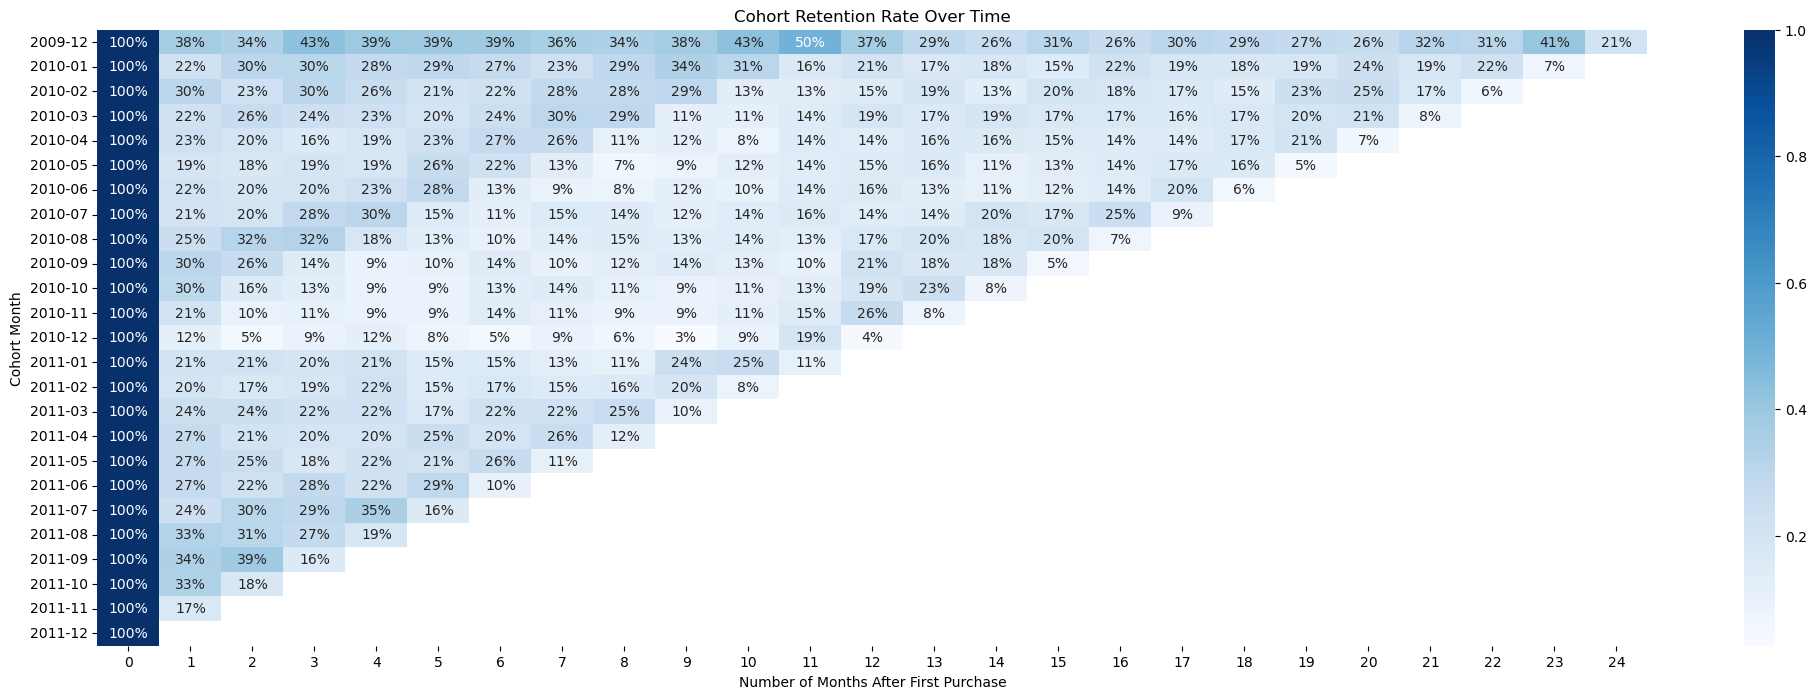

In [18]:
# Visualize the retention matrix
plt.figure(figsize=(25, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Retention Rate Over Time')
plt.xlabel('Number of Months After First Purchase')
plt.ylabel('Cohort Month')
plt.show()

**Calculate CLV and ARPU**

+ **Customer Lifetime Value (CLV):** CLV measures the total revenue a business can reasonably expect from a single customer account throughout the relationship.

+ **Average Revenue Per User (ARPU):** ARPU represents the revenue generated per user or customer, typically calculated monthly.

In [31]:
# Calculate Total Revenue per Customer
data['Revenue'] = data['Quantity'] * data['Price']
customer_revenue = data.groupby('CustomerID')['Revenue'].sum().reset_index()

# Calculate the number of days each customer is active
customer_lifetime = data.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max']).reset_index()
customer_lifetime['Lifetime'] = (customer_lifetime['max'] - customer_lifetime['min']).dt.days

# Merge revenue and lifetime data
customer_lifetime = customer_lifetime.merge(customer_revenue, on='CustomerID')

# Calculate ARPU (Average Revenue Per User)
customer_lifetime['ARPU'] = customer_lifetime['Revenue'] / customer_lifetime['Lifetime']

# Calculate CLV (assuming monthly retention and average lifespan)
customer_lifetime['CLV'] = customer_lifetime['ARPU'] * customer_lifetime['Lifetime']

In [32]:
customer_lifetime

,CustomerID,min,max,Lifetime,Revenue,ARPU,CLV
0,12346,2009-12-14 08:34:00,2011-01-18 10:17:00,400,-64.68,-0.161700,-64.68
1,12347,2010-10-31 14:20:00,2011-12-07 15:52:00,402,5633.32,14.013234,5633.32
2,12348,2010-09-27 14:59:00,2011-09-25 13:13:00,362,2019.40,5.578453,2019.40
3,12349,2009-12-04 12:49:00,2011-11-21 09:51:00,716,4404.54,6.151592,4404.54
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,0,334.40,inf,NaN
...,...,...,...,...,...,...,...
5937,18283,2010-02-19 17:16:00,2011-12-06 12:02:00,654,2736.65,4.184480,2736.65
5938,18284,2010-10-04 11:33:00,2010-10-06 12:31:00,2,436.68,218.340000,436.68
5939,18285,2010-02-17 10:24:00,2010-02-17 10:24:00,0,427.00,inf,NaN
5940,18286,2009-12-16 10:45:00,2010-08-20 11:57:00,247,1188.43,4.811457,1188.43


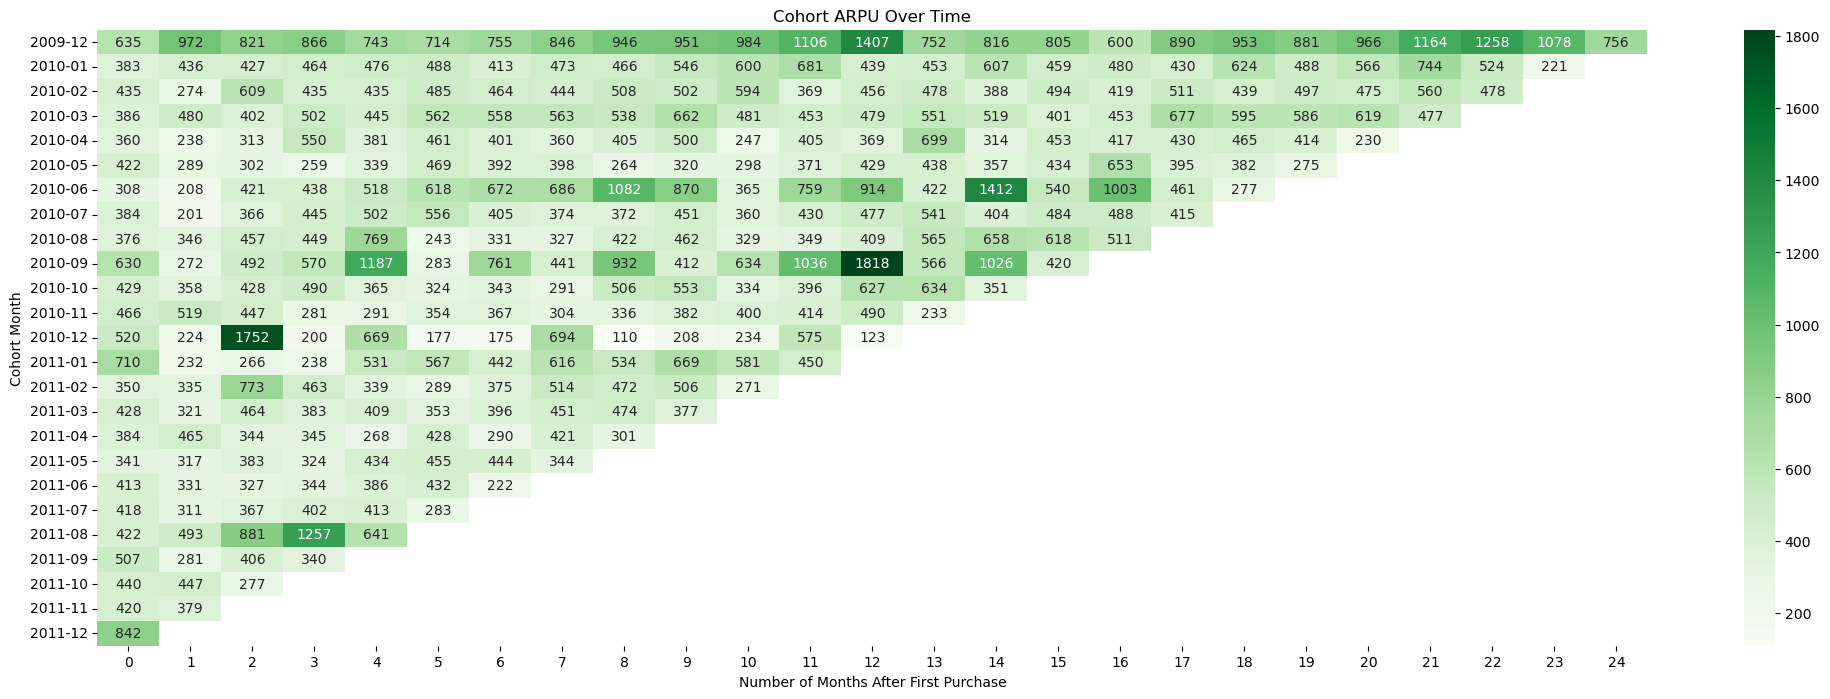

In [38]:
# Calculate CLV and ARPU by Cohort
cohort_revenue = data.groupby(['CohortMonth', 'CohortIndex'])['Revenue'].sum().reset_index()
cohort_revenue_pivot = cohort_revenue.pivot(index='CohortMonth', columns='CohortIndex', values='Revenue')

# Calculate ARPU by dividing total revenue by the number of customers in each cohort
cohort_arpu = cohort_revenue_pivot.divide(cohort_pivot, axis=0)

# Visualize CLV and ARPU
plt.figure(figsize=(25, 8))
sns.heatmap(cohort_arpu, annot=True, fmt='.0f', cmap='Greens')
plt.title('Cohort ARPU Over Time')
plt.xlabel('Number of Months After First Purchase')
plt.ylabel('Cohort Month')
plt.show()